<a href="https://colab.research.google.com/github/mdeniz1/datascienceprojects/blob/main/%22Car_Insurance_Pricing_Dynamics_Descriptive_Metrics_and_Sensitivity_analysis_in_Python%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


An insurance company provided a dataset that contains the data on car insurance between 2019-2022. The company manager would like to understand the reasons behind the steep fall in the profits for 2022 while the profits were good between 2019-2022. They also want to know what actions can be taken in terms of price or cost arrangements to increase the profits. As a response to this task, I applied descriptive, diagnostic and predictive analytics to both understand the problem and offer a solution to overcome it.
---



In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import shap
from catboost import Pool
import catboost as cb



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = r'/content/drive/My Drive/smp_train.xlsx'
df = pd.read_excel(path)

Workbook contains no default style, apply openpyxl's default


In [ ]:
df.head(100)

,YEAR,MONTH,POLICY_TYPE,NO_CLAIMS_LEVEL,COVER,CLAIM,CLAIM_FREQ,CUST_AGE,CUST_GENDER_F,LOCATION_URBAN,...,TYPE_CORP,VEHICLE_TYPE,VEHICLE_YEAR,FLAG_SPORTS_CAR,HOME_AGE,HOME_M2,LOC_INDEX,PRE_HEALTH_ISSUES,INSTALLMENTS,PREMIUM
0,2019,8,MOD,4,76450,66911,3,19,0,1,...,0,Mini Bus,2019,0,?,?,17,?,8,4834
1,2020,5,MOD,3,82650,65008,1,19,0,0,...,0,Personal Car,2019,1,?,?,30,?,12,2856
2,2019,10,MOD,1,37050,35060,1,23,0,1,...,0,Mini Bus,2016,1,?,?,93,?,8,3836
3,2020,7,MOD,1,29790,23593,1,27,1,0,...,0,Personal Car,2016,1,?,?,69,?,5,2222
4,2020,5,MOD,2,35840,33966,1,37,0,1,...,0,Mini Bus,2020,0,?,?,75,?,1,3566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020,9,MOD,5,16830,16164,1,34,1,1,...,0,Mini Truck,2013,0,?,?,96,?,1,3796
96,2019,12,MOD,2,16170,12661,1,52,1,1,...,0,Personal Car,2015,0,?,?,22,?,2,3642
97,2021,8,MOD,4,17710,10526,2,48,0,0,...,0,Personal Car,2015,0,?,?,49,?,2,4004
98,2021,7,MOD,5,13420,8785,1,59,0,1,...,0,Personal Car,2020,0,?,?,38,?,8,3030


The data has 25 features. I added one more feature, namely, ‘PROFIT’ by calculating it with the equation PROFIT=premiumX0.77-CLAIM.



In [ ]:
df['PROFIT']=df['PREMIUM']*0.77-df['CLAIM']

In [ ]:
unique_years = df['YEAR'].unique()
unique_years

array([2019, 2020, 2021])

In [ ]:
path = r'/content/drive/My Drive/smp_test.xlsx'
df2 = pd.read_excel(path)

Workbook contains no default style, apply openpyxl's default


In [ ]:
unique_years = df2['YEAR'].unique()
unique_years

array([2022])

In [ ]:
df2['PROFIT']=df2['PREMIUM']*0.77-df2['CLAIM']

In [ ]:
df2.head()

,YEAR,MONTH,POLICY_TYPE,NO_CLAIMS_LEVEL,COVER,CLAIM,CLAIM_FREQ,CUST_AGE,CUST_GENDER_F,LOCATION_URBAN,...,VEHICLE_TYPE,VEHICLE_YEAR,FLAG_SPORTS_CAR,HOME_AGE,HOME_M2,LOC_INDEX,PRE_HEALTH_ISSUES,INSTALLMENTS,PREMIUM,PROFIT
0,2022,6,MOD,0,61050,38737,1,61,1,0,...,Personal Car,2009,0,?,?,72,?,1,5582,-34438.86
1,2022,4,MOD,5,58370,33033,1,45,1,0,...,Personal Car,2015,0,?,?,31,?,9,3400,-30415.00
2,2022,3,MOD,5,71560,47131,1,61,0,1,...,Personal Car,2016,1,?,?,10,?,8,4116,-43961.68
3,2022,10,MOD,4,61340,22114,1,55,0,0,...,Personal Car,2017,0,?,?,58,?,9,4080,-18972.40
4,2022,1,MOD,3,36500,31604,1,51,1,1,...,Mini Truck,2013,0,?,?,33,?,10,2976,-29312.48


In [ ]:
if df.columns.equals(df2.columns):
    print('the two data frame columns equal each other')
else:
    print('they are different')

they are different


In [ ]:
merged_df = pd.concat([df, df2]).reset_index(drop=True)


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427 entries, 0 to 2426
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 2427 non-null   int64  
 1   MONTH                2427 non-null   int64  
 2   POLICY_TYPE          2427 non-null   object 
 3   NO_CLAIMS_LEVEL      2427 non-null   int64  
 4   COVER                2427 non-null   int64  
 5   CLAIM                2427 non-null   int64  
 6   CLAIM_FREQ           2427 non-null   int64  
 7   CUST_AGE             2427 non-null   int64  
 8   CUST_GENDER_F        2427 non-null   int64  
 9   LOCATION_URBAN       2427 non-null   int64  
 10  CLAIM_REASON         2427 non-null   object 
 11  CUST_INCOME          2427 non-null   int64  
 12  CUST_FINDEKS         2427 non-null   int64  
 13  CUST_EMPLOYMENT      2427 non-null   object 
 14  CUST_MARITAL_SINGLE  2427 non-null   int64  
 15  TYPE_CORP            2427 non-null   i

To understand the problem of profit, I first checked the change in annual average profit and realized that there is a sudden drop in profit in 2022.
Here is the graph

Text(0.5, 1.0, 'Average Profit Per Year')

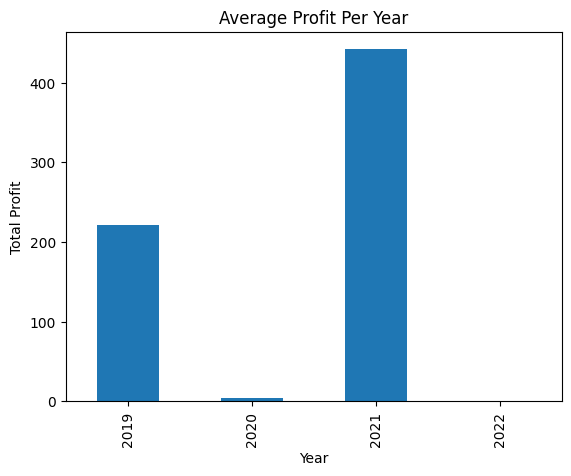

In [ ]:
merged_df.groupby(['YEAR'])['PROFIT'].mean().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Total Profit')
plt.title('Average Profit Per Year')



I then checked the usual culprits that influence the profit as revealed in the equation i.e PREMIUM and CLAIM. I also checked the cover column. Here are the average annual values of each feature as represented by bar charts.


Text(0.5, 1.0, 'Average Premium per Year')

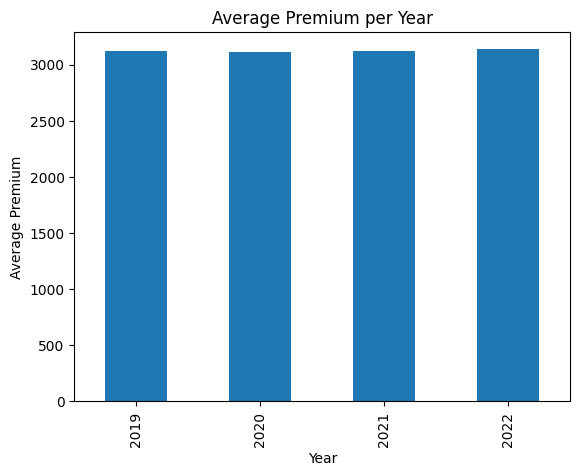

In [ ]:
merged_df.groupby(['YEAR'])['PREMIUM'].mean().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Average Premium')
plt.title('Average Premium per Year')



Text(0.5, 1.0, 'Average Claim per Year')

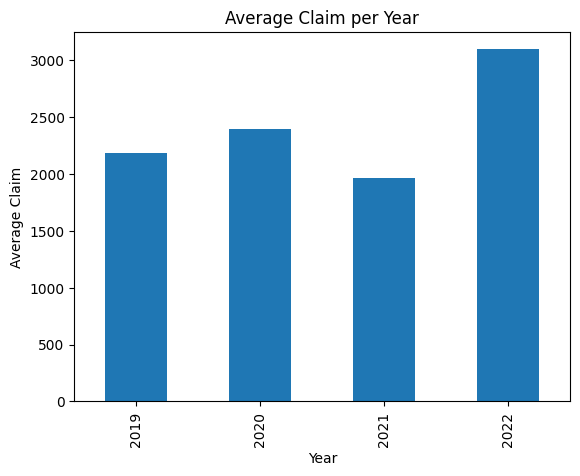

In [ ]:
merged_df.groupby(['YEAR'])['CLAIM'].mean().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Average Claim')
plt.title('Average Claim per Year')



Text(0.5, 1.0, 'Average Cover per Year')

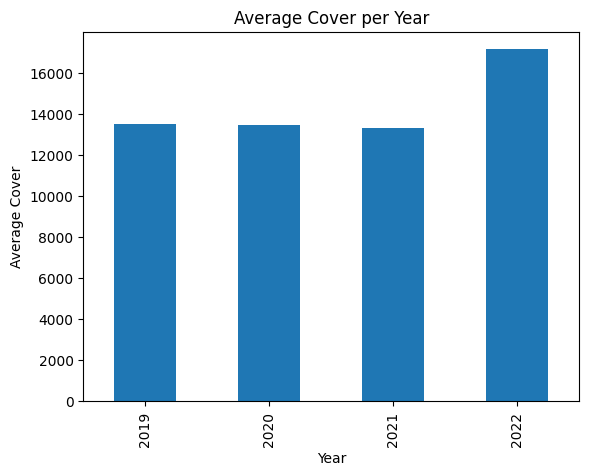

In [ ]:
merged_df.groupby(['YEAR'])['COVER'].mean().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Average Cover')
plt.title('Average Cover per Year')



As can be seen on the graphs, while the average premiums did not change over the years, there are sharp increases in average cover and premium values. So can they be the main reason for the fall in profit?I followed up with correlation analysis for numerical features to gain further insights on the issue.




Here is the correlation matrix


In [ ]:
#observing the correlation for all numerical column
correlation_matrix=merged_df[['PROFIT','CLAIM', 'PREMIUM','CLAIM_FREQ','NO_CLAIMS_LEVEL','NO_CLAIMS_LEVEL', 'COVER','CUST_AGE','VEHICLE_YEAR', 'CUST_INCOME', 'CUST_FINDEKS'  ]].corr(method='pearson')
print(correlation_matrix)

                   PROFIT     CLAIM   PREMIUM  CLAIM_FREQ  NO_CLAIMS_LEVEL  \
PROFIT           1.000000 -0.993388 -0.011848   -0.825665         0.051278   
CLAIM           -0.993388  1.000000  0.127530    0.806658        -0.040256   
PREMIUM         -0.011848  0.127530  1.000000    0.002009        -0.012336   
CLAIM_FREQ      -0.825665  0.806658  0.002009    1.000000         0.004535   
NO_CLAIMS_LEVEL  0.051278 -0.040256 -0.012336    0.004535         1.000000   
NO_CLAIMS_LEVEL  0.051278 -0.040256 -0.012336    0.004535         1.000000   
COVER           -0.449535  0.534642  0.635501    0.244427        -0.008776   
CUST_AGE         0.075971 -0.052351  0.003270   -0.019591        -0.028283   
VEHICLE_YEAR    -0.013011  0.013701 -0.026650    0.011934        -0.016245   
CUST_INCOME      0.010188 -0.044226 -0.013377   -0.030600         0.031820   
CUST_FINDEKS     0.044503 -0.039773 -0.007951    0.019398         0.000697   

                 NO_CLAIMS_LEVEL     COVER  CUST_AGE  VEHICLE_Y

Profit is highly negatively correlated with claim, claim_freq and cover features. Therefore, one would suspect a sharp increase in those features could potentially decrease the profits. one interesting observation is that premium is weakly correlated with profit although it is one of the two variables in the construction of the profit feature.

Correlation only shows a linear association among features yet it does not reveal how much one variable changes in relation to another variable. Moreover, it also does not show us a casual relationship. An ML model would help to explore the existence of non-linear as well as linear relationships among different variables in the dataset. That is why, I built a Catboost regressor model for sensitivity analysis of the profit on different variables.


In [ ]:
#checking the types of the features
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427 entries, 0 to 2426
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 2427 non-null   int64  
 1   MONTH                2427 non-null   int64  
 2   POLICY_TYPE          2427 non-null   object 
 3   NO_CLAIMS_LEVEL      2427 non-null   int64  
 4   COVER                2427 non-null   int64  
 5   CLAIM                2427 non-null   int64  
 6   CLAIM_FREQ           2427 non-null   int64  
 7   CUST_AGE             2427 non-null   int64  
 8   CUST_GENDER_F        2427 non-null   int64  
 9   LOCATION_URBAN       2427 non-null   int64  
 10  CLAIM_REASON         2427 non-null   object 
 11  CUST_INCOME          2427 non-null   int64  
 12  CUST_FINDEKS         2427 non-null   int64  
 13  CUST_EMPLOYMENT      2427 non-null   object 
 14  CUST_MARITAL_SINGLE  2427 non-null   int64  
 15  TYPE_CORP            2427 non-null   i

In [ ]:
#changing the type of object variables to string as catboost requires.
merged_df['POLICY_TYPE']=merged_df['POLICY_TYPE'].astype("string")
merged_df['CUST_GENDER_F']= merged_df['CUST_GENDER_F'].astype("string")
merged_df['CLAIM_REASON']= merged_df['CLAIM_REASON'].astype("string")
merged_df['CUST_EMPLOYMENT'] = merged_df['CUST_EMPLOYMENT'].astype("string")
merged_df['CUST_MARITAL_SINGLE'] = merged_df['CUST_MARITAL_SINGLE'].astype("string")
merged_df['VEHICLE_TYPE'] = merged_df['VEHICLE_TYPE'].astype("string")
merged_df['FLAG_SPORTS_CAR'] = merged_df['FLAG_SPORTS_CAR'].astype("string")
merged_df['LOCATION_URBAN'] = merged_df['LOCATION_URBAN'].astype("string")



In [ ]:
#preparing the train-test sets.

features = merged_df.drop(['PROFIT', 'NO_CLAIMS_LEVEL','CUST_AGE', 'VEHICLE_YEAR', 'TYPE_CORP', 'CUST_INCOME', 'CUST_FINDEKS','HOME_AGE','HOME_M2','LOC_INDEX','PRE_HEALTH_ISSUES', 'INSTALLMENTS'], axis=1)
target = merged_df['PROFIT'].values

# shuffle is zero so that we dont lose squential data.
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427 entries, 0 to 2426
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   YEAR                 2427 non-null   int64 
 1   MONTH                2427 non-null   int64 
 2   POLICY_TYPE          2427 non-null   string
 3   COVER                2427 non-null   int64 
 4   CLAIM                2427 non-null   int64 
 5   CLAIM_FREQ           2427 non-null   int64 
 6   CUST_GENDER_F        2427 non-null   string
 7   LOCATION_URBAN       2427 non-null   int64 
 8   CLAIM_REASON         2427 non-null   string
 9   CUST_EMPLOYMENT      2427 non-null   string
 10  CUST_MARITAL_SINGLE  2427 non-null   string
 11  VEHICLE_TYPE         2427 non-null   string
 12  FLAG_SPORTS_CAR      2427 non-null   string
 13  PREMIUM              2427 non-null   int64 
dtypes: int64(7), string(7)
memory usage: 265.6 KB


Model 1 with a set of hyperparameters

In [ ]:

params = {
    'iterations': randint(100, 1000),
    'depth': randint(3, 10),
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(32, 255),
    'bagging_temperature': [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
}

cv = TimeSeriesSplit(n_splits=5)

# the model and GridSearchCV
model = CatBoostRegressor(loss_function='RMSE', od_type='Iter', cat_features=[ 2, 5, 7, 8, 9, 11, 12], task_type='GPU')
search = RandomizedSearchCV(model, param_distributions=params, n_iter=15, cv=cv, scoring='neg_root_mean_squared_error')
# Fit the model
search.fit(X_train, y_train, plot=True)

In [ ]:
search.best_params_

{'bagging_temperature': 0.6,
 'border_count': 166,
 'depth': 5,
 'iterations': 965,
 'l2_leaf_reg': 3,
 'learning_rate': 0.05}

In [ ]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate the RMSE scores
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print('Best CV error: {:.4f}'.format(best_cv_error))

print('RMSE score of the best estimator on the test set:', rmse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean absolute percentage error score of the best estimator on the test set:', mape)

# Calculate training error
y_train_pred = best_model.predict(X_train)
best_training_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('Training RMSE of the best model:', best_training_error)

# Calculate CV error
best_cv_error = -search.best_score_
print('Best CV error:', best_cv_error)


RMSE score of the best estimator on the test set: 298.02609026693034
Mean absolute percentage error score of the best estimator on the test set: 13.42884222113189
Training RMSE of the best model: 238.73825107731415
Best CV error: 1448.5698228072538


Model 2 with a set of new hyperparameters as model 1 overfits the data

In [ ]:

params = {
    'iterations': randint(100, 1000),
    'depth': randint(3, 10),
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(32, 255),
    'bagging_temperature': [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
}

cv = TimeSeriesSplit(n_splits=5)

# the model and GridSearchCV
model = CatBoostRegressor(loss_function='RMSE', od_type='Iter', cat_features=[ 2, 5, 7, 8, 9, 11, 12], task_type='GPU')
search2 = RandomizedSearchCV(model, param_distributions=params, n_iter=15, cv=cv, scoring='neg_root_mean_squared_error')
# Fit the model
search2.fit(X_train, y_train, plot=True)

In [ ]:
search2.best_params_

{'bagging_temperature': 0.8,
 'border_count': 229,
 'depth': 3,
 'iterations': 649,
 'l2_leaf_reg': 4,
 'learning_rate': 0.05}

In [ ]:
best_model = search2.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate the RMSE scores
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print('Best CV error: {:.4f}'.format(best_cv_error))

print('RMSE score of the best estimator on the test set:', rmse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean absolute percentage error score of the best estimator on the test set:', mape)

# Calculate training error
y_train_pred = best_model.predict(X_train)
best_training_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('Training RMSE of the best model:', best_training_error)

# Calculate CV error
best_cv_error = -search.best_score_
print('Best CV error:', best_cv_error)


RMSE score of the best estimator on the test set: 255.88707594604034
Mean absolute percentage error score of the best estimator on the test set: 12.566394101679077
Training RMSE of the best model: 289.60082449922413
Best CV error: 1490.2774160181295


Model 3 with a set of new hyperparameters and with fewer features as model 2 overfits the data

In [ ]:
params = {
    'iterations': randint(100, 1000),
    'depth': [1,2,3,4,5],
    'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.06],
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(32, 255),
    'bagging_temperature': [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
}

cv = TimeSeriesSplit(n_splits=4)

# the model and GridSearchCV
model = CatBoostRegressor(loss_function='RMSE', od_type='Iter', cat_features=[ 2, 5, 7, 8, 9, 10,11], task_type='GPU')
search3 = RandomizedSearchCV(model, param_distributions=params, n_iter=30, cv=cv, scoring='neg_root_mean_squared_error')
# Fit the model
search3.fit(X_train, y_train, plot=True)

In [ ]:
search3.best_params_

{'bagging_temperature': 1.0,
 'border_count': 232,
 'depth': 1,
 'iterations': 934,
 'l2_leaf_reg': 9,
 'learning_rate': 0.04}

In [ ]:
best_model = search3.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate the RMSE scores
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print('Best CV error: {:.4f}'.format(best_cv_error))

print('RMSE score of the best estimator on the test set:', rmse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean absolute percentage error score of the best estimator on the test set:', mape)

# Calculate training error
y_train_pred = best_model.predict(X_train)
best_training_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('Training RMSE of the best model:', best_training_error)

# Calculate CV error
best_cv_error = -search3.best_score_
print('Best CV error:', best_cv_error)


RMSE score of the best estimator on the test set: 480.93564336370656
Mean absolute percentage error score of the best estimator on the test set: 25.91379977527297
Training RMSE of the best model: 488.85272629738006
Best CV error: 570.9229501853597


Model 4 with a set of new hyperparameters and with fewer as model 2 overfits the data

In [ ]:
params = {
    'iterations': randint(100, 1000),
    'depth': [1,2,3,4,5],
    'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.06],
    'l2_leaf_reg': randint(1, 10),
    'border_count': randint(32, 255),
    'bagging_temperature': [ 0.6, 0.8, 1.0,1.1,1.2],
}

cv = TimeSeriesSplit(n_splits=4)

# the model and GridSearchCV
model = CatBoostRegressor(loss_function='RMSE', od_type='Iter', cat_features=[ 2, 6, 7, 8, 9, 10,11,12], task_type='GPU')
New_search = RandomizedSearchCV(model, param_distributions=params, n_iter=40, cv=cv, scoring='neg_root_mean_squared_error',  error_score='raise')
# Fit the model
New_search.fit(X_train, y_train, plot=True)

In [ ]:
best_model = New_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate the RMSE scores
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print('Best CV error: {:.4f}'.format(best_cv_error))

print('RMSE score of the best estimator on the test set:', rmse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('Mean absolute percentage error score of the best estimator on the test set:', mape)

# Calculate training error
y_train_pred = best_model.predict(X_train)
best_training_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('Training RMSE of the best model:', best_training_error)

# Calculate CV error
best_cv_error = -New_search.best_score_
print('Best CV error:', best_cv_error)


RMSE score of the best estimator on the test set: 113.76467818124635
Mean absolute percentage error score of the best estimator on the test set: 5.178174575360201
Training RMSE of the best model: 118.96618032904139
Best CV error: 387.5318995853154


I built several models using scikitlearn’s randomizedCV model which I fed different sets of hyperparameters for Catboost. Note that, I have chosen catboost for its sound method of dealing with categorical features since the dataset includes 8 different categorical features. After having a decent enough non-overfitted model, I performed two analysis to understand how the model reveals the relationship between variables.
a) shap summary plot
b) sensitivity analysis based on the results of shap summary plot


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


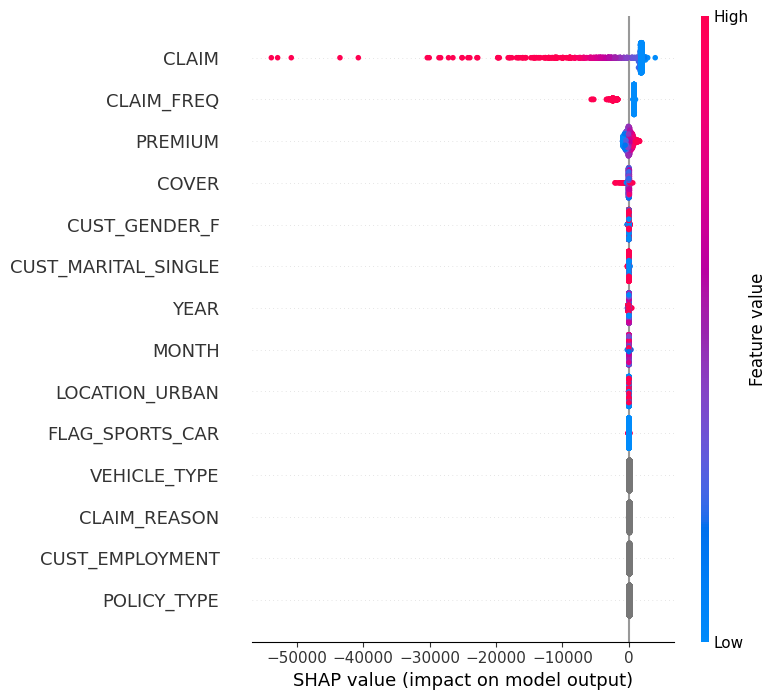

In [ ]:
bestmodel=New_search.best_estimator_
shap_values = shap.TreeExplainer(best_model).shap_values(Pool(features,target, cat_features=[ 2, 6, 7, 8, 9, 10,11,12]))
shap.summary_plot(shap_values, features)





Shap is a method that presents how much each variable contributed to the target and it creates a plot to show the contribution of the variables. .When we look at the graph above, we realize that CLAIM CLAIM FREQ and COVER are important features for the model with CLAIM being the most important. One interesting observation is that premium emerged as an important feature that positively contributes to the profit. Another unexpected observation is that COVER’s effect is ambiguous despite the fact that Pearson correlation analysis showed a strong negative correlation for COVER.


In [ ]:
best_model=New_search.best_estimator_

In [ ]:
best_model.save_model('/content/drive/My Drive/model2.cbm')

In [ ]:

loaded_model = cb.CatBoost().load_model('/content/drive/My Drive/model.cbm')

Here, I use my catboost model to perform Sensitivity Analysis. This will help me to understand how much changes in different important features such as CLAIM, Claim Freaquency and Cover cause a decline or an increase in the profits.

In [ ]:
ypred=loaded_model.predict(features)

In [ ]:
pred_df=features.copy()
pred_df['PROFIT']=ypred

In [ ]:
annual_AVG_Cover=pred_df.groupby(['YEAR'])['COVER'].mean()
annual_AVG_CLAIM=pred_df.groupby(['YEAR'])['CLAIM'].mean()
annual_AVG_PROFIT=pred_df.groupby(['YEAR'])['PROFIT'].mean()
print(annual_AVG_Cover)


print(annual_AVG_CLAIM)

print(annual_AVG_PROFIT)

YEAR
2019    13520.241935
2020    13449.419795
2021    13309.261006
2022    17128.401709
Name: COVER, dtype: float64
YEAR
2019    2179.522581
2020    2394.148464
2021    1964.100629
2022    3090.194872
Name: CLAIM, dtype: float64
YEAR
2019    218.534915
2020      3.881163
2021    438.147668
2022   -645.151413
Name: PROFIT, dtype: float64


In [ ]:
new_features=features.copy()
new_features['CLAIM_FREQ']=features['CLAIM_FREQ']*0.5
ypred_new=New_search.predict(new_features)
df_new=new_features.copy()
df_new['PROFIT']=ypred_new


In [ ]:
annual_AVG_Cover=df_new.groupby(['YEAR'])['COVER'].mean()
annual_AVG_CLAIM=df_new.groupby(['YEAR'])['CLAIM'].mean()
annual_AVG_PROFIT=df_new.groupby(['YEAR'])['PROFIT'].mean()
#annual_claim_freq=pred_df.groupby(['YEAR'])['CLAIM_FREQ'].mean()
print(annual_AVG_Cover)


print(annual_AVG_CLAIM)

print(annual_AVG_PROFIT)

YEAR
2019    13520.241935
2020    13449.419795
2021    13309.261006
2022    17128.401709
Name: COVER, dtype: float64
YEAR
2019    2179.522581
2020    2394.148464
2021    1964.100629
2022    3090.194872
Name: CLAIM, dtype: float64
YEAR
2019    681.452485
2020    583.006349
2021    890.196930
2022     14.671988
Name: PROFIT, dtype: float64


In [ ]:
new_features=features.copy()
new_features['CLAIM']=features['CLAIM']*0.5
ypred_new=loaded_model.predict(new_features)
df_new=new_features.copy()
df_new['PROFIT']=ypred_new


In [ ]:
annual_AVG_Cover=df_new.groupby(['YEAR'])['COVER'].mean()
annual_AVG_CLAIM=df_new.groupby(['YEAR'])['CLAIM'].mean()
annual_AVG_PROFIT=df_new.groupby(['YEAR'])['PROFIT'].mean()
#annual_claim_freq=pred_df.groupby(['YEAR'])['CLAIM_FREQ'].mean()
print(annual_AVG_Cover)


print(annual_AVG_CLAIM)

print(annual_AVG_PROFIT)

YEAR
2019    13520.241935
2020    13449.419795
2021    13309.261006
2022    17128.401709
Name: COVER, dtype: float64
YEAR
2019    1089.761290
2020    1197.074232
2021     982.050314
2022    1545.097436
Name: CLAIM, dtype: float64
YEAR
2019    1272.335034
2020    1149.638284
2021    1368.501804
2022    1095.301203
Name: PROFIT, dtype: float64


after several rounds of trials with different levels of COVER, PREMIUM and CLAIM, I found out that


**Premium**: 10 % increase for premium causes 30% increase in the profit

 **claim**: 10 % increase for claim causes 47 % decrease in the profit

**claim** **frequency**: while a 10% reduction doesn't change PROFIT much, 50% reduction caused a 102% increase for the profit.


At the end of the sensitivity analysis, the feature with the highest effect on profit is the claim feature as 10% increases causes the highest decrease in profit. Increasing premium also substantially increases profit. while a %10 reduction in claim frequency doesn't chang profit at all, 50%reduction caused a 102% increase for the profit.

I offer two solutions to the profit problem. The first one is rewarding customers with low claims with lower premiums. the premium distribution for 2022 did not reflect this proposition so 2023 premiums should be arranged according to the past claims. Second proposol is again increasing premiums by %10 especially for customers with high past claims. Again 2022 average premiums were similar to the previous years regardless of past claims. Rearranging premiums based on claims would boost the premiums.